<a href="https://colab.research.google.com/github/Taghr66d/MSc-SummerProject2025/blob/main/CuspNewPSDSNR500_2000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pycbc gwpy gwosc numpy scipy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 7.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 11.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━

In [6]:

import os
import numpy as np
from numpy.fft import rfft, rfftfreq, irfft
from scipy.signal import windows
from gwpy.timeseries import TimeSeries
from astropy import units as u
from tqdm import tqdm

#  Config
DET        = "H1"
FS         = 1024
DT         = 1.0 / FS
FULL_DUR   = 16.0         # seconds pulled from open data
CROP_DUR   = 2.0          # seconds per sample
SIG_DUR    = 1.0          # cusp length
LOWCUT     = 20.0         # high-pass / SNR low cutoff
FFT_WHITEN = 4.0          # whiten fftlength (match PSD)
PSD_OVERLP = 2.0

N_SAMPLES  = 10
SNR_LOW, SNR_HIGH = 500.0, 2000.0

DO_ZSCORE  = True         # False to keep whitened amplitude as-is

# keep crops >= (FFT_WHITEN/2) from each edge + half the crop
SAFE_SAMPLES = int(FS * (FFT_WHITEN / 2.0))
MARGIN      = SAFE_SAMPLES + int(FS * (CROP_DUR / 2.0))
OUT_SAMPLES = int(FS * CROP_DUR)

rng = np.random.default_rng(12345)
script_index = 0
gps_start = 1126259456 + script_index * max(3*N_SAMPLES, 30)  # generous spacing

#  Helpers
def cusp_signal(amplitude=9.85e-22, f_high=340.0, dt=1/1024, duration=1.0, low_freq_cutoff=20.0):
    """Frequency-domain cusp |H(f)| ∝ f^(-4/3) with exponential roll-off above f_high,
       centered in the 1 s window, synthesized via irfft."""
    N = int(round(duration / dt))
    freqs = rfftfreq(N, d=dt)
    H = np.zeros_like(freqs, dtype=complex)

    mask = freqs >= low_freq_cutoff
    fpos = freqs[mask]
    spec = fpos ** (-4.0/3.0)
    tail = fpos >= f_high
    if np.any(tail):
        spec[tail] *= np.exp(1.0 - fpos[tail] / f_high)
    H[mask] = amplitude * spec
    H *= np.exp(-2j * np.pi * freqs * (duration / 2.0))  # center burst
    return irfft(H, n=N).real

def compute_standard_snr(signal, dt, psd_vals, psd_freqs, low_freq_cutoff=20.0):
    """One-sided <s|s> = 4 ∫ |S(f)|^2 / S_n(f) df (using rfft bins)."""
    N = len(signal)
    df = 1.0 / (N * dt)
    freqs = rfftfreq(N, d=dt)
    S = rfft(signal) * dt
    band = freqs >= low_freq_cutoff
    if not np.any(band):
        return 0.0
    Sn = np.interp(freqs[band], psd_freqs, psd_vals, left=np.inf, right=np.inf)
    good = np.isfinite(Sn) & (Sn > 0)
    if not np.any(good):
        return 0.0
    snr2 = 4.0 * np.sum((np.abs(S[band][good])**2) / Sn[good]) * df
    return float(np.sqrt(max(snr2, 0.0)))

#  Buffer
X = np.zeros((N_SAMPLES, OUT_SAMPLES), dtype=np.float32)
y = np.ones(N_SAMPLES, dtype=np.int32)  # 1 = cusp
snr_t_list, snr_obs_list = [], []
fhigh_list, inj_idx_list = [], []

print("Generating 10 ultra-SNR cusp injections in real H1 noise...")
success = 0

for i in tqdm(range(N_SAMPLES * 5)):
    if success >= N_SAMPLES:
        break
    gps = gps_start + i * int(FULL_DUR + 10)  # step forward to avoid reuse

    try:
        # 1) Fetch 16 s of real strain and resample
        ts = TimeSeries.fetch_open_data(DET, gps, gps + FULL_DUR)
        ts = ts.crop(ts.t0, ts.t0 + FULL_DUR * u.s).resample(FS)
        noise = ts.value.copy()

        # 2) Measure PSD on same stretch (after high-pass)
        ts_psd = TimeSeries(noise, dt=DT).highpass(LOWCUT)
        psd = ts_psd.psd(fftlength=FFT_WHITEN, overlap=PSD_OVERLP)
        psd_f = psd.frequencies.value.astype(float)
        psd_v = psd.value.astype(float)

        # 3) Build cusp (1 s), taper, and scale to ultra SNR
        snr_target = float(rng.uniform(SNR_LOW, SNR_HIGH))
        f_high = float(rng.uniform(150.0, 340.0))  # keep realistic band
        cusp = cusp_signal(f_high=f_high, dt=DT, duration=SIG_DUR, low_freq_cutoff=LOWCUT)
        cusp *= windows.tukey(len(cusp), alpha=0.2, sym=True)

        snr_meas = compute_standard_snr(cusp, DT, psd_v, psd_f, LOWCUT)
        if snr_meas <= 0 or not np.isfinite(snr_meas):
            continue
        cusp *= (snr_target / snr_meas)   # enforce target SNR
        snr_obs = compute_standard_snr(cusp, DT, psd_v, psd_f, LOWCUT)

        # 4) Inject into UNWHITENED noise with safe margins
        max_inject_start = len(noise) - len(cusp)
        if max_inject_start <= 2 * MARGIN:
            continue
        inject_start = rng.integers(MARGIN, max_inject_start - MARGIN + 1)
        noise[inject_start:inject_start + len(cusp)] += cusp

        # 5) Whiten full 16 s with same PSD settings
        white = TimeSeries(noise, dt=DT).highpass(LOWCUT).whiten(fftlength=FFT_WHITEN, overlap=PSD_OVERLP).value

        # 6) Crop 2 s that contains the event and is inside safe region
        start_range = max(MARGIN, inject_start - OUT_SAMPLES // 2)
        end_range   = min(len(white) - MARGIN - OUT_SAMPLES,
                          inject_start + len(cusp) - OUT_SAMPLES // 2)
        if end_range <= start_range:
            continue
        seg_start = rng.integers(start_range, end_range + 1)
        seg = white[seg_start:seg_start + OUT_SAMPLES].astype(np.float64, copy=True)
        inj_local = int(inject_start - seg_start)

        # 7) z-score
        if DO_ZSCORE:
            mu, sd = float(np.mean(seg)), float(np.std(seg))
            if sd == 0.0 or not np.isfinite(sd):
                continue
            seg = (seg - mu) / sd

        # 8) Buffer & meta
        X[success] = seg.astype(np.float32)
        y[success] = 1
        snr_t_list.append(snr_target)
        snr_obs_list.append(snr_obs)
        fhigh_list.append(f_high)
        inj_idx_list.append(inj_local)
        success += 1

    except Exception as e:
        # skip any bad GPS segments
        continue

#  Save
outdir = "UltraSNR_Cusp"; os.makedirs(outdir, exist_ok=True)
outfile = os.path.join(outdir, f"Cusp_RealNoise_{success}samples_ultraSNR.npz")
np.savez_compressed(
    outfile,
    X=X[:success],
    y=y[:success],
    snr=np.asarray(snr_t_list, dtype=np.float32),
    snr_check=np.asarray(snr_obs_list, dtype=np.float32),
    inject_idx=np.asarray(inj_idx_list, dtype=np.int32),
    f_high=np.asarray(fhigh_list, dtype=np.float32),
    meta=dict(detector=DET, fs=FS, full_duration=FULL_DUR, crop_duration=CROP_DUR,
              whitening_fftlength=FFT_WHITEN, whitening_overlap=PSD_OVERLP,
              highpass=LOWCUT, zscore=DO_ZSCORE, snr_range=(SNR_LOW, SNR_HIGH))
)
print(f"Saved {success} samples -> {outfile}")
print("Median fractional SNR error:",
      float(np.median(np.abs(np.asarray(snr_obs_list)-np.asarray(snr_t_list)) /
                      np.asarray(snr_t_list))) if success else "n/a")

Generating 10 ultra-SNR cusp injections in real H1 noise...


 20%|██        | 10/50 [00:27<01:49,  2.75s/it]

Saved 10 samples -> UltraSNR_Cusp/Cusp_RealNoise_10samples_ultraSNR.npz
Median fractional SNR error: 0.0


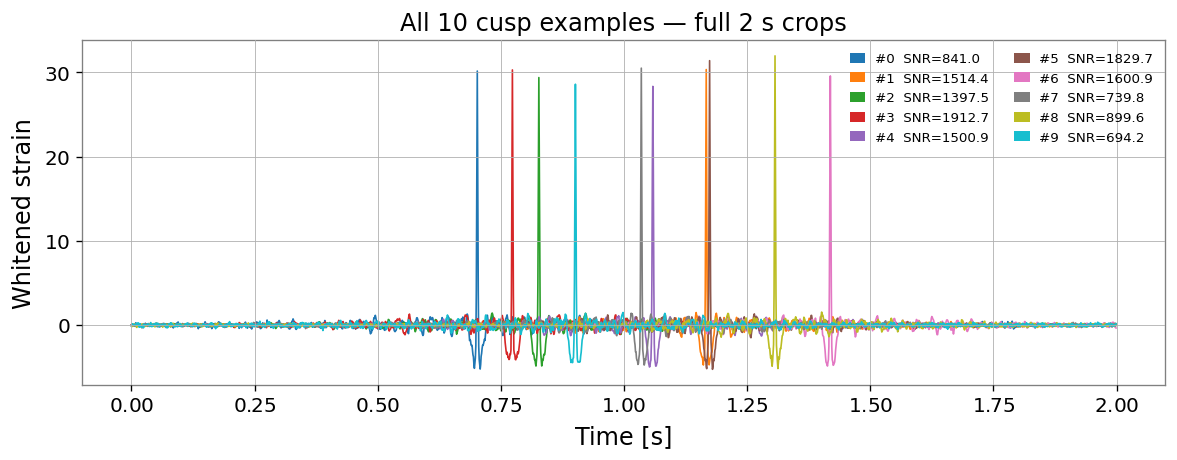

In [7]:
import numpy as np
import matplotlib.pyplot as plt


npz_path = "UltraSNR_Cusp/Cusp_RealNoise_10samples_ultraSNR.npz"
#npz_path = "UltraSNR_Cusp/Cusp_RealNoise_10samples_ultraSNR_NoZ.npz"
#npz_path = "UltraSNR_Cusp/Cusp_RealNoise_10samples_ultraSNR2.npz"


# options
OVERLAY = True         # False = one subplot per sample
SHADE_INJECTED = True   # show the 1s injected window
DPI = 120               # fig resolution
LINEWIDTH = 1.0


D = np.load(npz_path, allow_pickle=True)
X   = D["X"]                    # (N, 2048)
inj = D["inject_idx"]
snr = D["snr"]
snr_check = D["snr_check"]
meta = D["meta"].item() if "meta" in D else {}
fs = int(meta.get("fs", 1024))
sig_len = int(fs * 1.0)         # 1s injected window
N = X.shape[0]
t = np.arange(X.shape[1]) / fs


if OVERLAY:
    fig, ax = plt.subplots(figsize=(10, 4), dpi=DPI)
    for i in range(N):
        ax.plot(t, X[i], lw=LINEWIDTH, label=f"#{i}  SNR={snr[i]:.1f}")
        if SHADE_INJECTED:
            t0 = inj[i]/fs
            t1 = min(len(X[i]), inj[i] + sig_len)/fs
            #ax.axvspan(t0, t1, alpha=0.08)
            #ax.axvline(t0, ls="--", lw=0.8)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Whitened strain")# (z-score)")
    ax.set_title(f"All {N} cusp examples — full 2 s crops")
    ax.legend(ncol=2, fontsize=8, frameon=False)
    plt.tight_layout()
    plt.show()
else:
    # one subplot per sample
    height_per = 1.7  # inches per row
    fig, axes = plt.subplots(N, 1, figsize=(10, max(2, height_per*N)), sharex=True, dpi=DPI)
    if N == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        ax.plot(t, X[i], lw=LINEWIDTH)
        if SHADE_INJECTED:
            t0 = inj[i]/fs
            t1 = min(len(X[i]), inj[i] + sig_len)/fs
            #ax.axvspan(t0, t1, alpha=0.12, label=None)
            #ax.axvline(t0, ls="--", lw=0.8)
        ttl = f"#{i} — SNR={snr[i]:.1f} (obs {snr_check[i]:.1f})"
        ax.set_ylabel("z-score")
        ax.set_title(ttl, loc="left", fontsize=10)
    axes[-1].set_xlabel("Time [s]")
    fig.suptitle(f"Cusp injections — full 2 s crops (N={N}", y=0.995)
    plt.tight_layout()
    plt.show()


In [5]:
print("min/max SNR:", float(snr.min()), float(snr.max()))
print("median frac error:", float(np.median(np.abs(snr - snr_check)/snr)))


min/max SNR: 694.20361328125 1912.704345703125
median frac error: 0.0
